In [ ]:
# Libraries and helpers

# Librarires
import numpy as np
import matplotlib.pyplot as plt

# Set up repo root path
import os
os.chdir("../..")

# Helpers
from analysis.history_aware_relative_stratified_training_load import config as sub_config

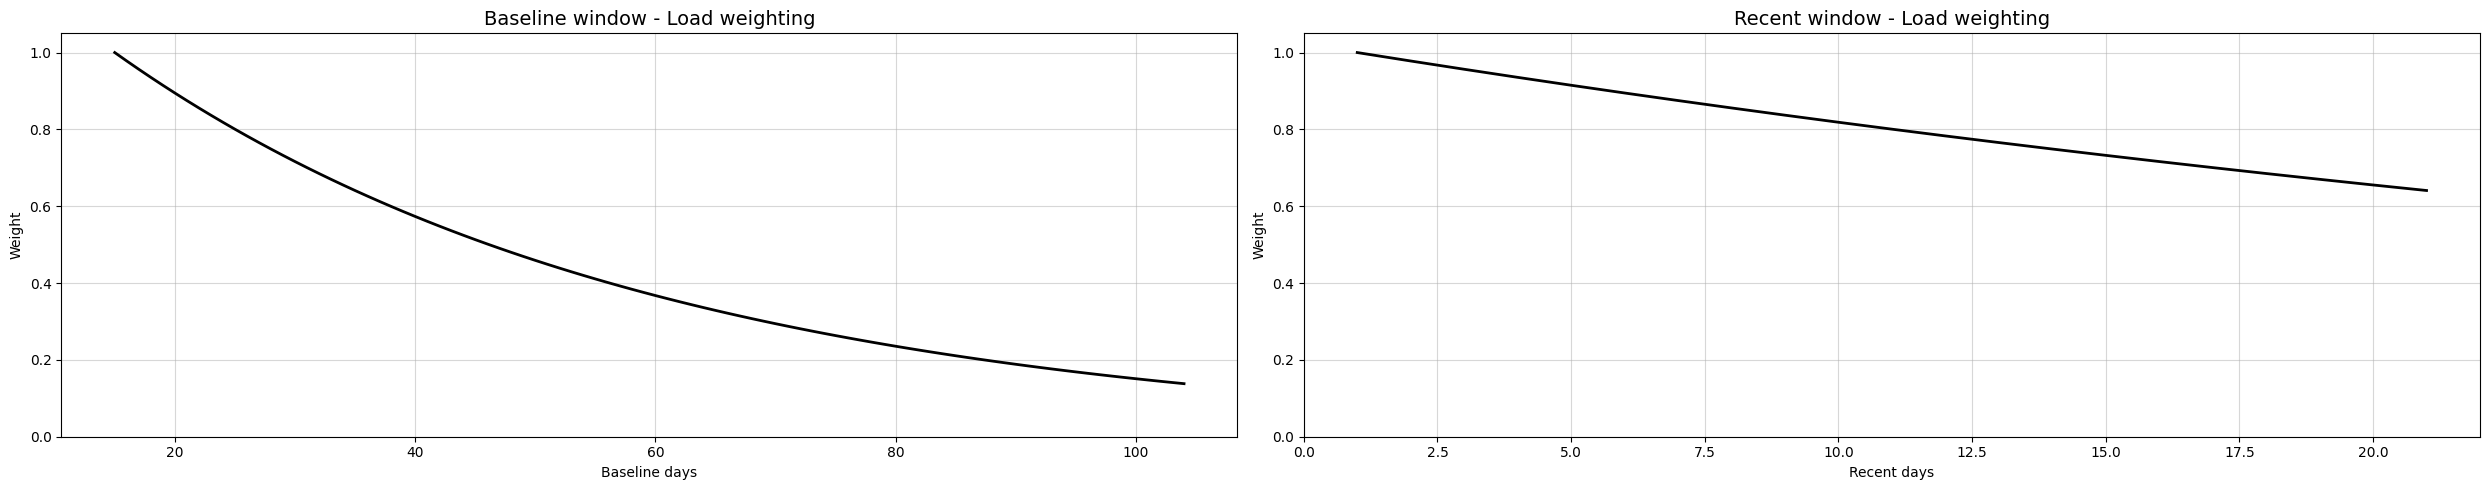

In [10]:
# How do we weight the days?

fig, ax = plt.subplots(1,2, figsize=(25,5))

ax[0].set_title("Baseline window - Load weighting", fontsize=14)
baseline_window_days = range(1, sub_config.BASELINE_WINDOW+1)
baseline_window_weights = np.array([sub_config.LAMBDA_BASE ** (j-1) for j in baseline_window_days])
ax[0].plot(np.repeat(14, 90) + baseline_window_days, baseline_window_weights, color="black", linewidth=2)
ax[0].set_xlabel("Baseline days")


ax[1].set_title("Recent window - Load weighting", fontsize=14)
recent_window_days = range(1, sub_config.RECENT_WINDOW+1)
recent_window_weights = np.array([sub_config.LAMBDA_BASE ** (j-1) for j in recent_window_days])
ax[1].plot(recent_window_days, recent_window_weights, color="black", linewidth=2)
ax[1].set_xlabel("Recent days")

for i in [0,1]:
    ax[i].set_ylim(0,1.05)
    ax[i].set_ylabel("Weight")
    ax[i].grid(alpha=0.5)

plt.tight_layout()
plt.show()

fig.savefig("analysissaved_filed.png", dpi=150, bbox_inches="tight")